# Laboratorio 1 - Data Science

Sara Paguaga 20634

Guillermo Santos 191517

In [181]:
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import statsmodels.api as sm
import statsmodels.stats.diagnostic as diag
import pandas as pd
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from apyori import apriori

import math

# Preguntas de Interés
- ¿Fumar és un factor significativo en un diagnóstico de cáncer cervical?
- ¿Tener un diagnóstico de alguna enfermedad sexual implica un mayor impacto en un diagnóstico de cancer?


# Preparación de datos

In [182]:
# Cargando dataset con pandas
data = pd.read_csv('risk_factors_cervical_cancer.csv')
data = pd.DataFrame(data)
data = data.replace('?', np.nan) # Reemplazando ? por NaN para un uso posterior.
data.columns = ['age', 'num_sexual_partners', 'first_sexual_intercourse', 
                'num_pregnancies', 'smokes', 'smokes_years', 'smokes_packs_year', 
                'hormonal_contraceptives', 'hormonal_contraceptives_years', 
								'iud', 'iud_years', 'stds', 'stds_number', 'stds_condylomatosis', 
                'stds_cervical_condylomatosis', 'stds_vaginal_condylomatosis', 
								'stds_vulvo_perineal_condylomatosis', 'stds_syphilis', 'stds_pelvic_inflammatory_disease', 
                'stds_genital_herpes', 'stds_molluscum_contagiosum', 'stds_aids', 'stds_hiv', 'stds_hepatitis_b', 
								'stds_hpv', 'stds_number_of_diagnosis', 'stds_time_since_first_diagnosis', 'stds_time_since_last_diagnosis', 
								'dx_cancer', 'dx_cin', 'dx_hpv', 'dx', 'hinselmann', 'schiller', 'citology', 'biopsy'
]

missing_values = data.isnull().sum()	# Contando valores faltantes
#print(missing_values)
# Eliminar iuid y iud_years
data = data.drop(['iud', 'iud_years', 'stds_cervical_condylomatosis'], axis=1)
# Replace '1.0' and '0.0' with 1 and 0
data = data.replace('1.0', 1)
data = data.replace('0.0', 0)
# Convertir a float
data = data.astype(float)


### Definiendo tipo de variables

* **Age** - (Cuantitativa discreta)
* **Number of sexual partners** - (Cuantitativa discreta)
* **First sexual intercourse** - (Cuantitativa discreta)
* **Num of pregnancies** - (Cuantitativa discreta)
* **Smokes** - (Cualitativa)
* **Smokes years** - (Cuantitativa discreta)
* **Smokes packs/year** - (Cuantitativa discreta)
* **Hormonal contraceptives** - (Cualitativa)
* **Hormonal contraceptives years** - (Cuantitativa discreta)
* **STDs** - (Cualitativa)
* **STDs number** - (Cuantitativa discreta)
* **STDs (condylomatosis)** - (Cualitativa)
* **STDs (cervical condylomatosis)** - (Cualitativa)
* **STDs (vaginal condylomatosis)** - (Cualitativa)
* **STDs (vulvo-perineal condylomatosis)** - (Cualitativa)
* **STDs (syphilis)** - (Cualitativa)
* **STDs (pelvic inflammatory disease)** - (Cualitativa)
* **STDs (genital herpes)** - (Cualitativa)
* **STDs (molluscum contagiosum)** - (Cualitativa)
* **STDs (AIDS)** - (Cualitativa)
* **STDs (HIV)** - (Cualitativa)
* **STDs (Hepatitis B)** - (Cualitativa)
* **STDs (HPV)** - (Cualitativa)
* **STDs (Number of diagnosis)** - (Cuantitativa discreta)
* **STDs (Time since first diagnosis)** - (Cuantitativa continua)
* **STDs (Time since last diagnosis)** - (Cuantitativa continua)
* **Dx (Cancer)** - (Cualitativa)
* **Dx (CIN)** - (Cualitativa)
* **Dx (HPV)** - (Cualitativa)
* **Dx (Cancer)** - (Cualitativa)
* **Dx** - (Cualitativa)
* **Hinselmann** - (Cualitativa)
* **Schiller** - (Cualitativa)
* **Citology** - (Cualitativa)
* **Biopsy** - (Cualitativa)


### Obteniendo tipo de variables

In [183]:
categorical_vars = ['dx_cancer', 'dx_cin', 'dx_hpv', 'dx', 'hinselmann', 'schiller', 'citology', 'biopsy', 'smokes', 'stds', 'stds_condylomatosis', 'stds_vaginal_condylomatosis', 'stds_vulvo_perineal_condylomatosis', 'stds_syphilis','stds_pelvic_inflammatory_disease', 'stds_genital_herpes', 'stds_molluscum_contagiosum', 'stds_aids', 'stds_hiv', 'stds_hepatitis_b', 'stds_hpv']
cuantitative_vars = ['age', 'num_sexual_partners', 'first_sexual_intercourse', 'num_pregnancies', 'smokes_years', 'smokes_packs_year', 'hormonal_contraceptives_years', 'stds_number', 'stds_number_of_diagnosis', 'stds_time_since_first_diagnosis', 'stds_time_since_last_diagnosis']

### Estadística descriptiva - Variables cuantitativas

In [184]:
data[categorical_vars].describe()

dx_cancer      dx_cin      dx_hpv          dx  hinselmann    schiller   
count  858.000000  858.000000  858.000000  858.000000  858.000000  858.000000  \
mean     0.020979    0.010490    0.020979    0.027972    0.040793    0.086247   
std      0.143398    0.101939    0.143398    0.164989    0.197925    0.280892   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

         citology      biopsy      smokes        stds  ...   
count  858.000000  858.000000  845.000000  753.000000  ...  \
mean     0.051282    0.064103    0.145562    0.104914  ...   
std      0.220701    0.245078    0.352876    0.306646  ...   
min      0.000000    0.000000    0.000000    0.000000  ...   
25%      0.000000    0.000000    0.000000    0.000000  ...   
50%      0.000000    0.000000    0.000000    0.000000  ...   
75%      0.000000    0.000000    0.000000    0.000000  ...   
max      1.000000    1.000000    1.000000    1.000000  ...   

       stds_vaginal_condylomatosis  stds_vulvo_perineal_condylomatosis   
count                   753.000000                          753.000000  \
mean                      0.005312                            0.057105   
std                       0.072739                            0.232197   
min                       0.000000                            0.000000   
25%                       0.000000                            0.000000   
50%                       0.000000                            0.000000   
75%                       0.000000                            0.000000   
max                       1.000000                            1.000000   

       stds_syphilis  stds_pelvic_inflammatory_disease  stds_genital_herpes   
count     753.000000                        753.000000           753.000000  \
mean        0.023904                          0.001328             0.001328   
std         0.152853                          0.036442             0.036442   
min         0.000000                          0.000000             0.000000   
25%         0.000000                          0.000000             0.000000   
50%         0.000000                          0.000000             0.000000   
75%         0.000000                          0.000000             0.000000   
max         1.000000                          1.000000             1.000000   

       stds_molluscum_contagiosum  stds_aids    stds_hiv  stds_hepatitis_b   
count                  753.000000      753.0  753.000000        753.000000  \
mean                     0.001328        0.0    0.023904          0.001328   
std                      0.036442        0.0    0.152853          0.036442   
min                      0.000000        0.0    0.000000          0.000000   
25%                      0.000000        0.0    0.000000          0.000000   
50%                      0.000000        0.0    0.000000          0.000000   
75%                      0.000000        0.0    0.000000          0.000000   
max                      1.000000        0.0    1.000000          1.000000   

         stds_hpv  
count  753.000000  
mean     0.002656  
std      0.051503  
min      0.000000  
25%      0.000000  
50%      0.000000  
75%      0.000000  
max      1.000000  

[8 rows x 21 columns]

### Estudiando variables numéricas

#### Histogramas

In [185]:
frequency_cols = 3
n = len(cuantitative_vars)
rows = math.ceil(n / frequency_cols) 

fig = make_subplots(rows=rows, cols=frequency_cols, subplot_titles=cuantitative_vars, specs=[[{'type': 'histogram'}]*frequency_cols]*rows, vertical_spacing=0.04, horizontal_spacing=0.1)
fig.update_layout(autosize=False, width=1000, height=500*rows, showlegend=False)

for i, var in enumerate(cuantitative_vars, start=1):
    data[var] = pd.to_numeric(data[var], errors='coerce')
    row, col = int((i-1)/frequency_cols)+1, int((i-1)%frequency_cols)+1
    fig.add_trace(go.Histogram(x=data[var], nbinsx=20, nbinsy=5, name=var, showlegend=False, marker=dict(color='#636EFA')), row=row, col=col)

fig.show()

Se puede notar en los histogramas de las variables del estudio que todas presentan un sesgo negativo. En cuanto al rango de edad de las mujeres que participaron en la investigación, la mayoría se sitúa entre los 15 y los 50 años, destacándose un subgrupo de mujeres de 20 a 24 años con 214 observaciones. Los histogramas que representan la frecuencia de consumo de tabaco (smokes_year y smokes_packs_year) se evidencia que la mayor parte de estas mujeres no poseen el hábito de fumar. Asimismo, se concluye que un número significativo de las mujeres en el estudio opta por no usar anticonceptivos hormonales.

#### Cajas de bigotes

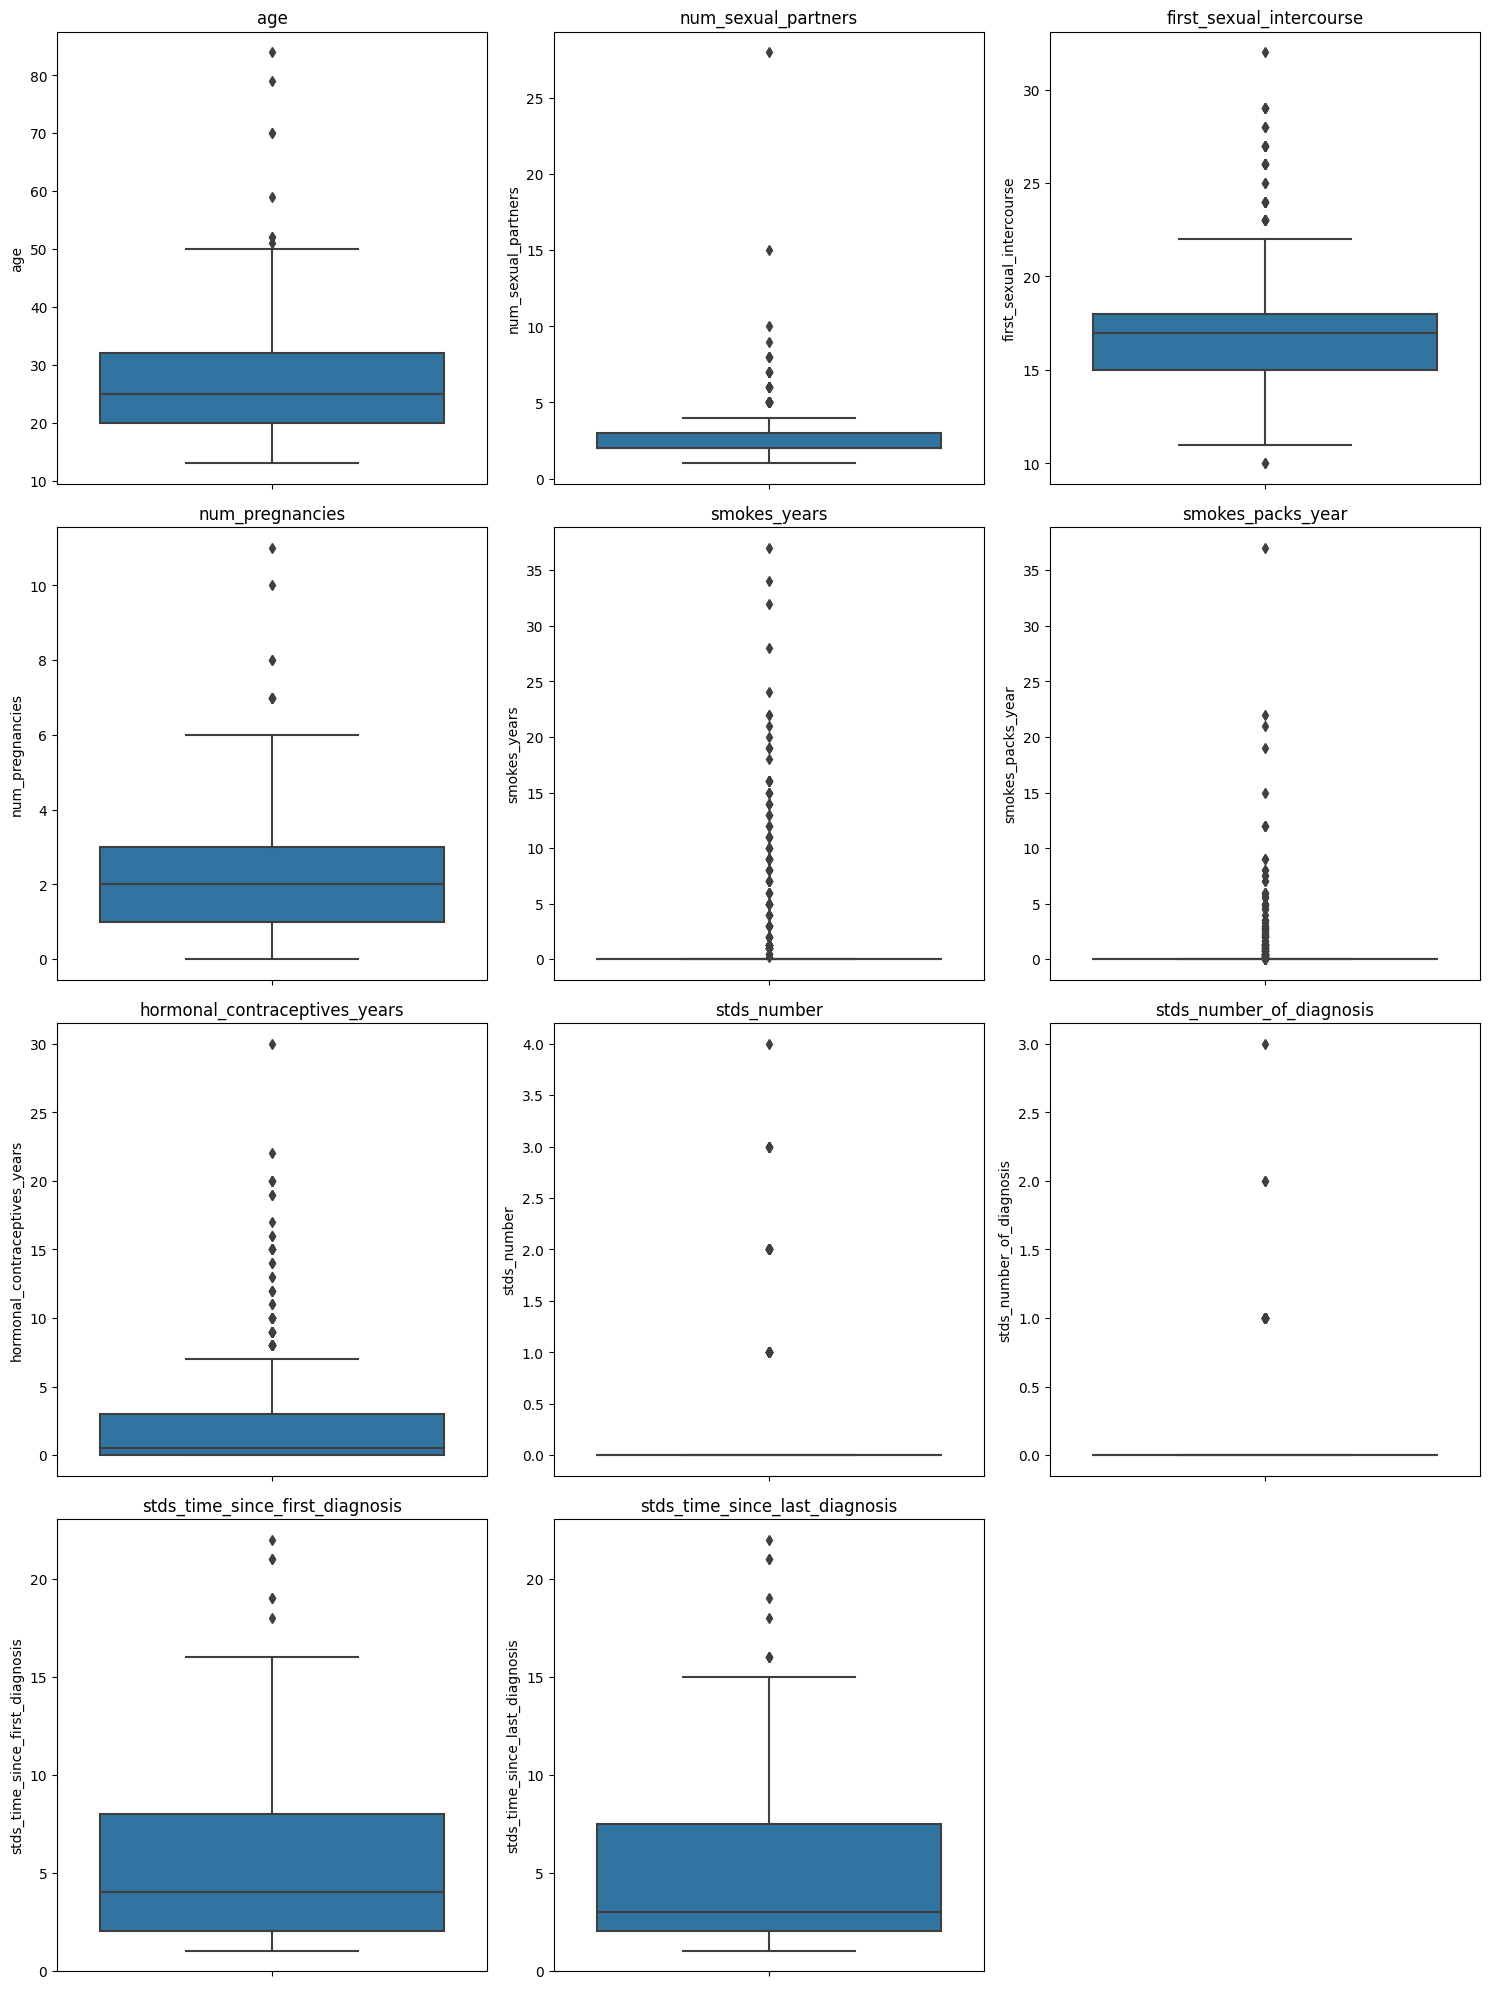

In [186]:
frequency_rows = len(cuantitative_vars) // 3 + 1
frequency_cols = 3

fig, axs = plt.subplots(frequency_rows, frequency_cols, figsize=(15, 5 * frequency_rows))
axs = axs.flatten()

for ax, var in zip(axs, cuantitative_vars):
    data[var] = pd.to_numeric(data[var], errors='coerce')
    sns.boxplot(y=var, data=data, ax=ax)
    ax.set_title(var)

for ax in axs[len(cuantitative_vars):]:
    ax.axis('off')

plt.tight_layout()

plt.show()


Las variables con la mayor cantidad de valores atípicos son num_sexual_partners (cantidad de parejas sexuales), first_sexual_intercourse (primera relación sexual), smokes_years (años fumando), smokes_packs_year (paquetes de cigarros al año) y hormonal_contraceptives_year (años usando anticonceptivos hormonales). 

Por otro lado, la variable num_sexual_partners (cantidad de parejas sexuales) es la que muestra menor dispersión. Las variables que presentan la mayor dispersión de datos, según el tamaño de sus cajas en el diagrama, son stds_time_since_first_diagnosis (tiempo desde el primer diagnóstico de ETS) y stds_time_since_last_diagnosis (tiempo desde el último diagnóstico de ETS).

Finalmente, respecto a las variables age (edad de la paciente) y num_pregnancies (cantidad de embarazos), la distribución de los datos es aproximadamente simétrica, como se observa la posición de la línea en el diagrama de caja.

#### Graficos de dispersión

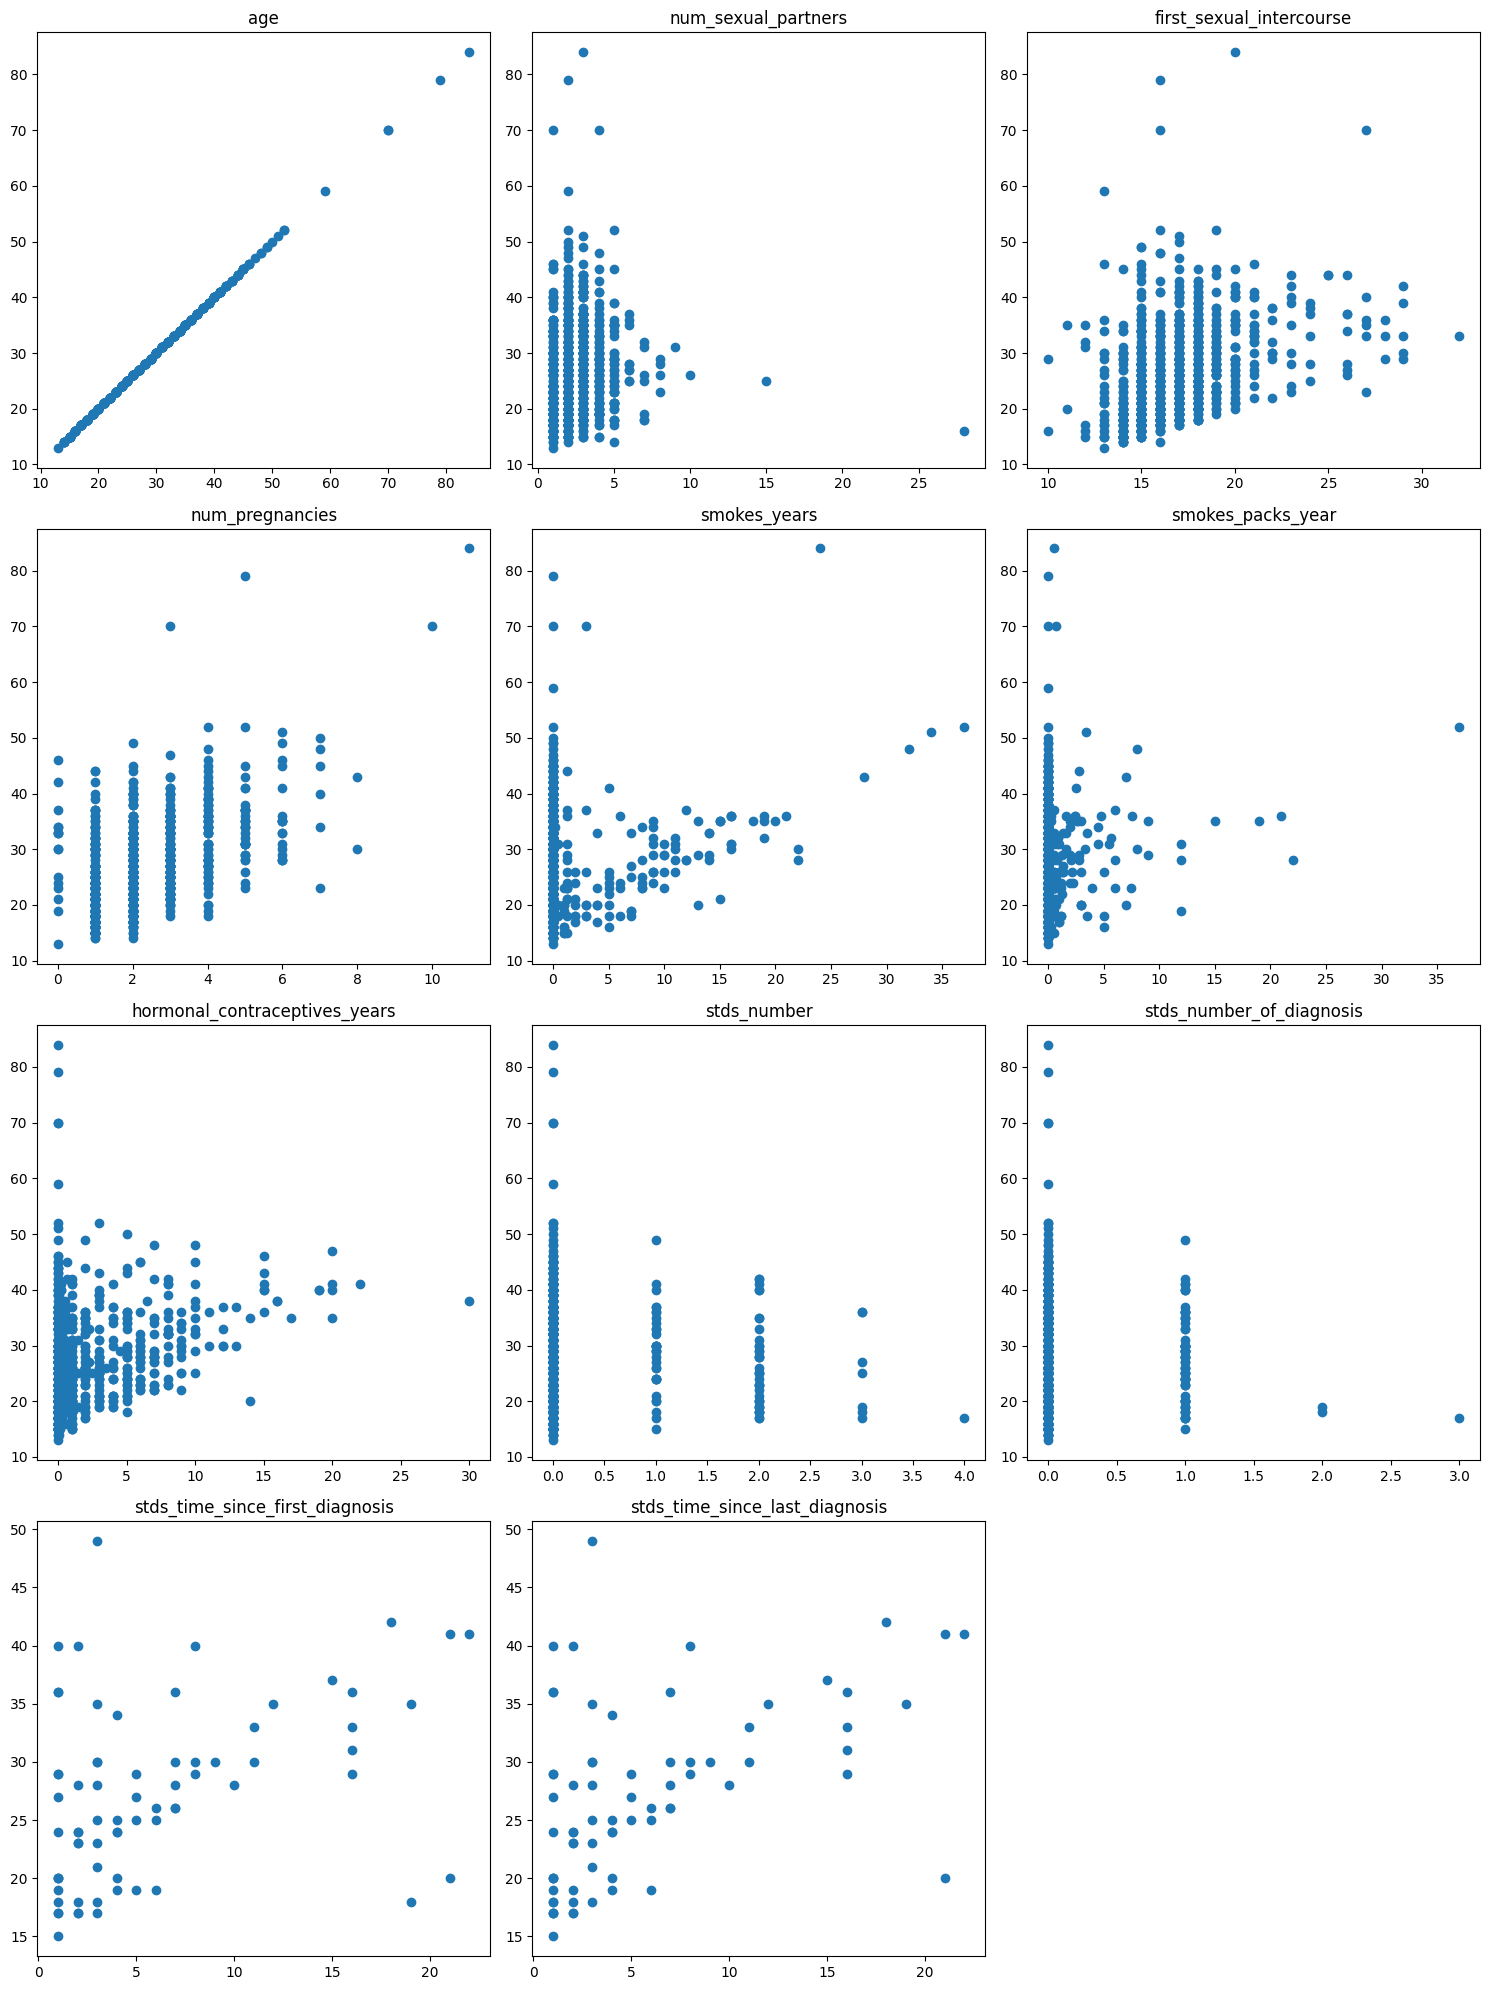

In [187]:
frequency_rows = len(cuantitative_vars) // 3 + 1
frequency_cols = 3

fig, axs = plt.subplots(frequency_rows, frequency_cols, figsize=(15, 5 * frequency_rows))
axs = axs.flatten()

for ax, var in zip(axs, cuantitative_vars):
    data[var] = pd.to_numeric(data[var], errors='coerce')
    ax.scatter(data[var], data['age'])
    ax.set_title(var)

for ax in axs[len(cuantitative_vars):]:
    ax.axis('off')

plt.tight_layout()

Las variables con datos más dispersos son: first_sexual_intercourse (primera relación sexual), num_pregnancies(cantidad de embarazos), stds_time_since_first_diagnosis (tiempo desde el primer diagnóstico de ETS) y stds_time_since_last_diagnosis (tiempo desde el último diagnóstico de ETS).

### Correlación de variables y datos atípicos


<Axes: >

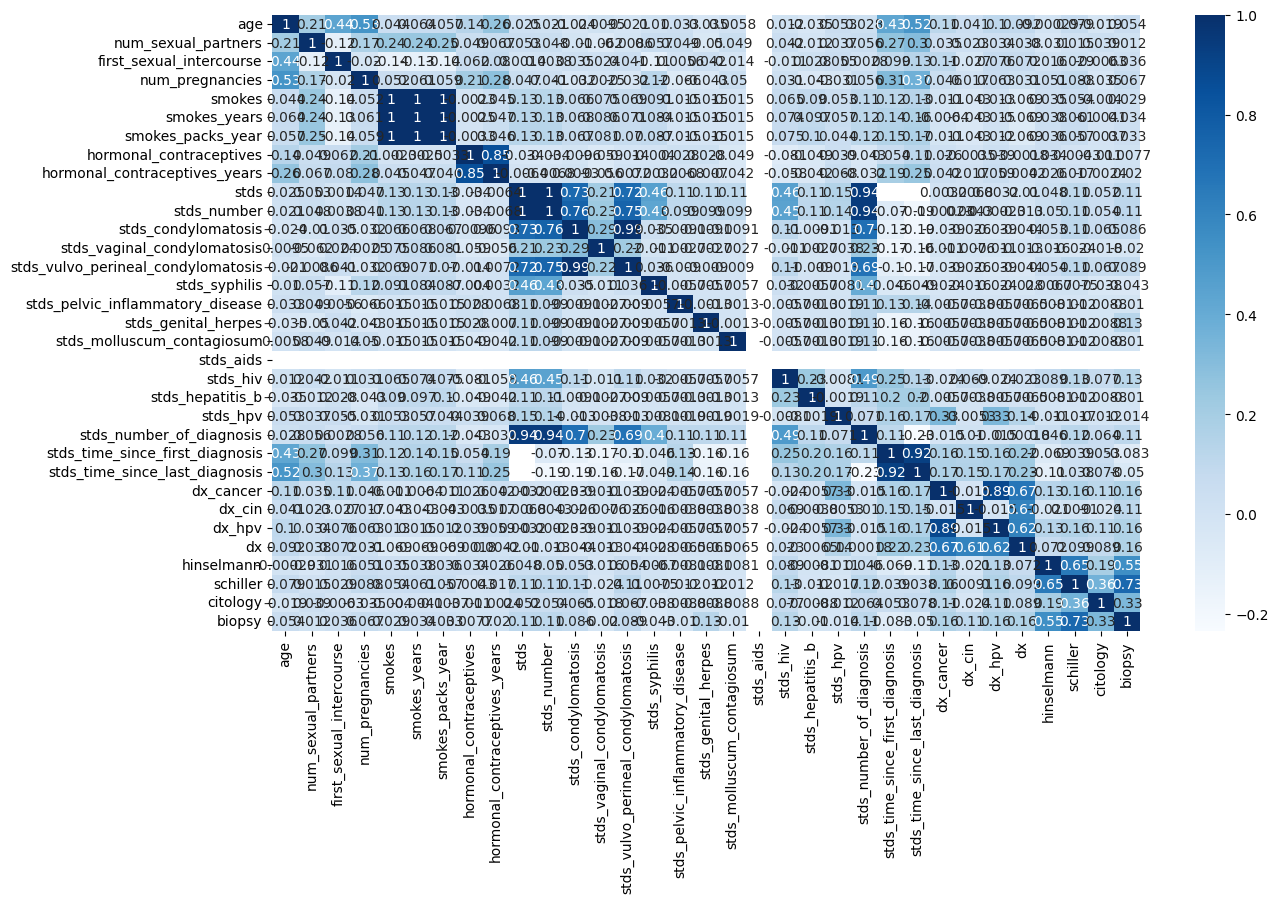

In [188]:
plt.figure(figsize=(14,8))
sns.heatmap(data.corr(numeric_only=True,method='spearman'), annot=True, cmap='Blues')

### Estudiando variables categoricas

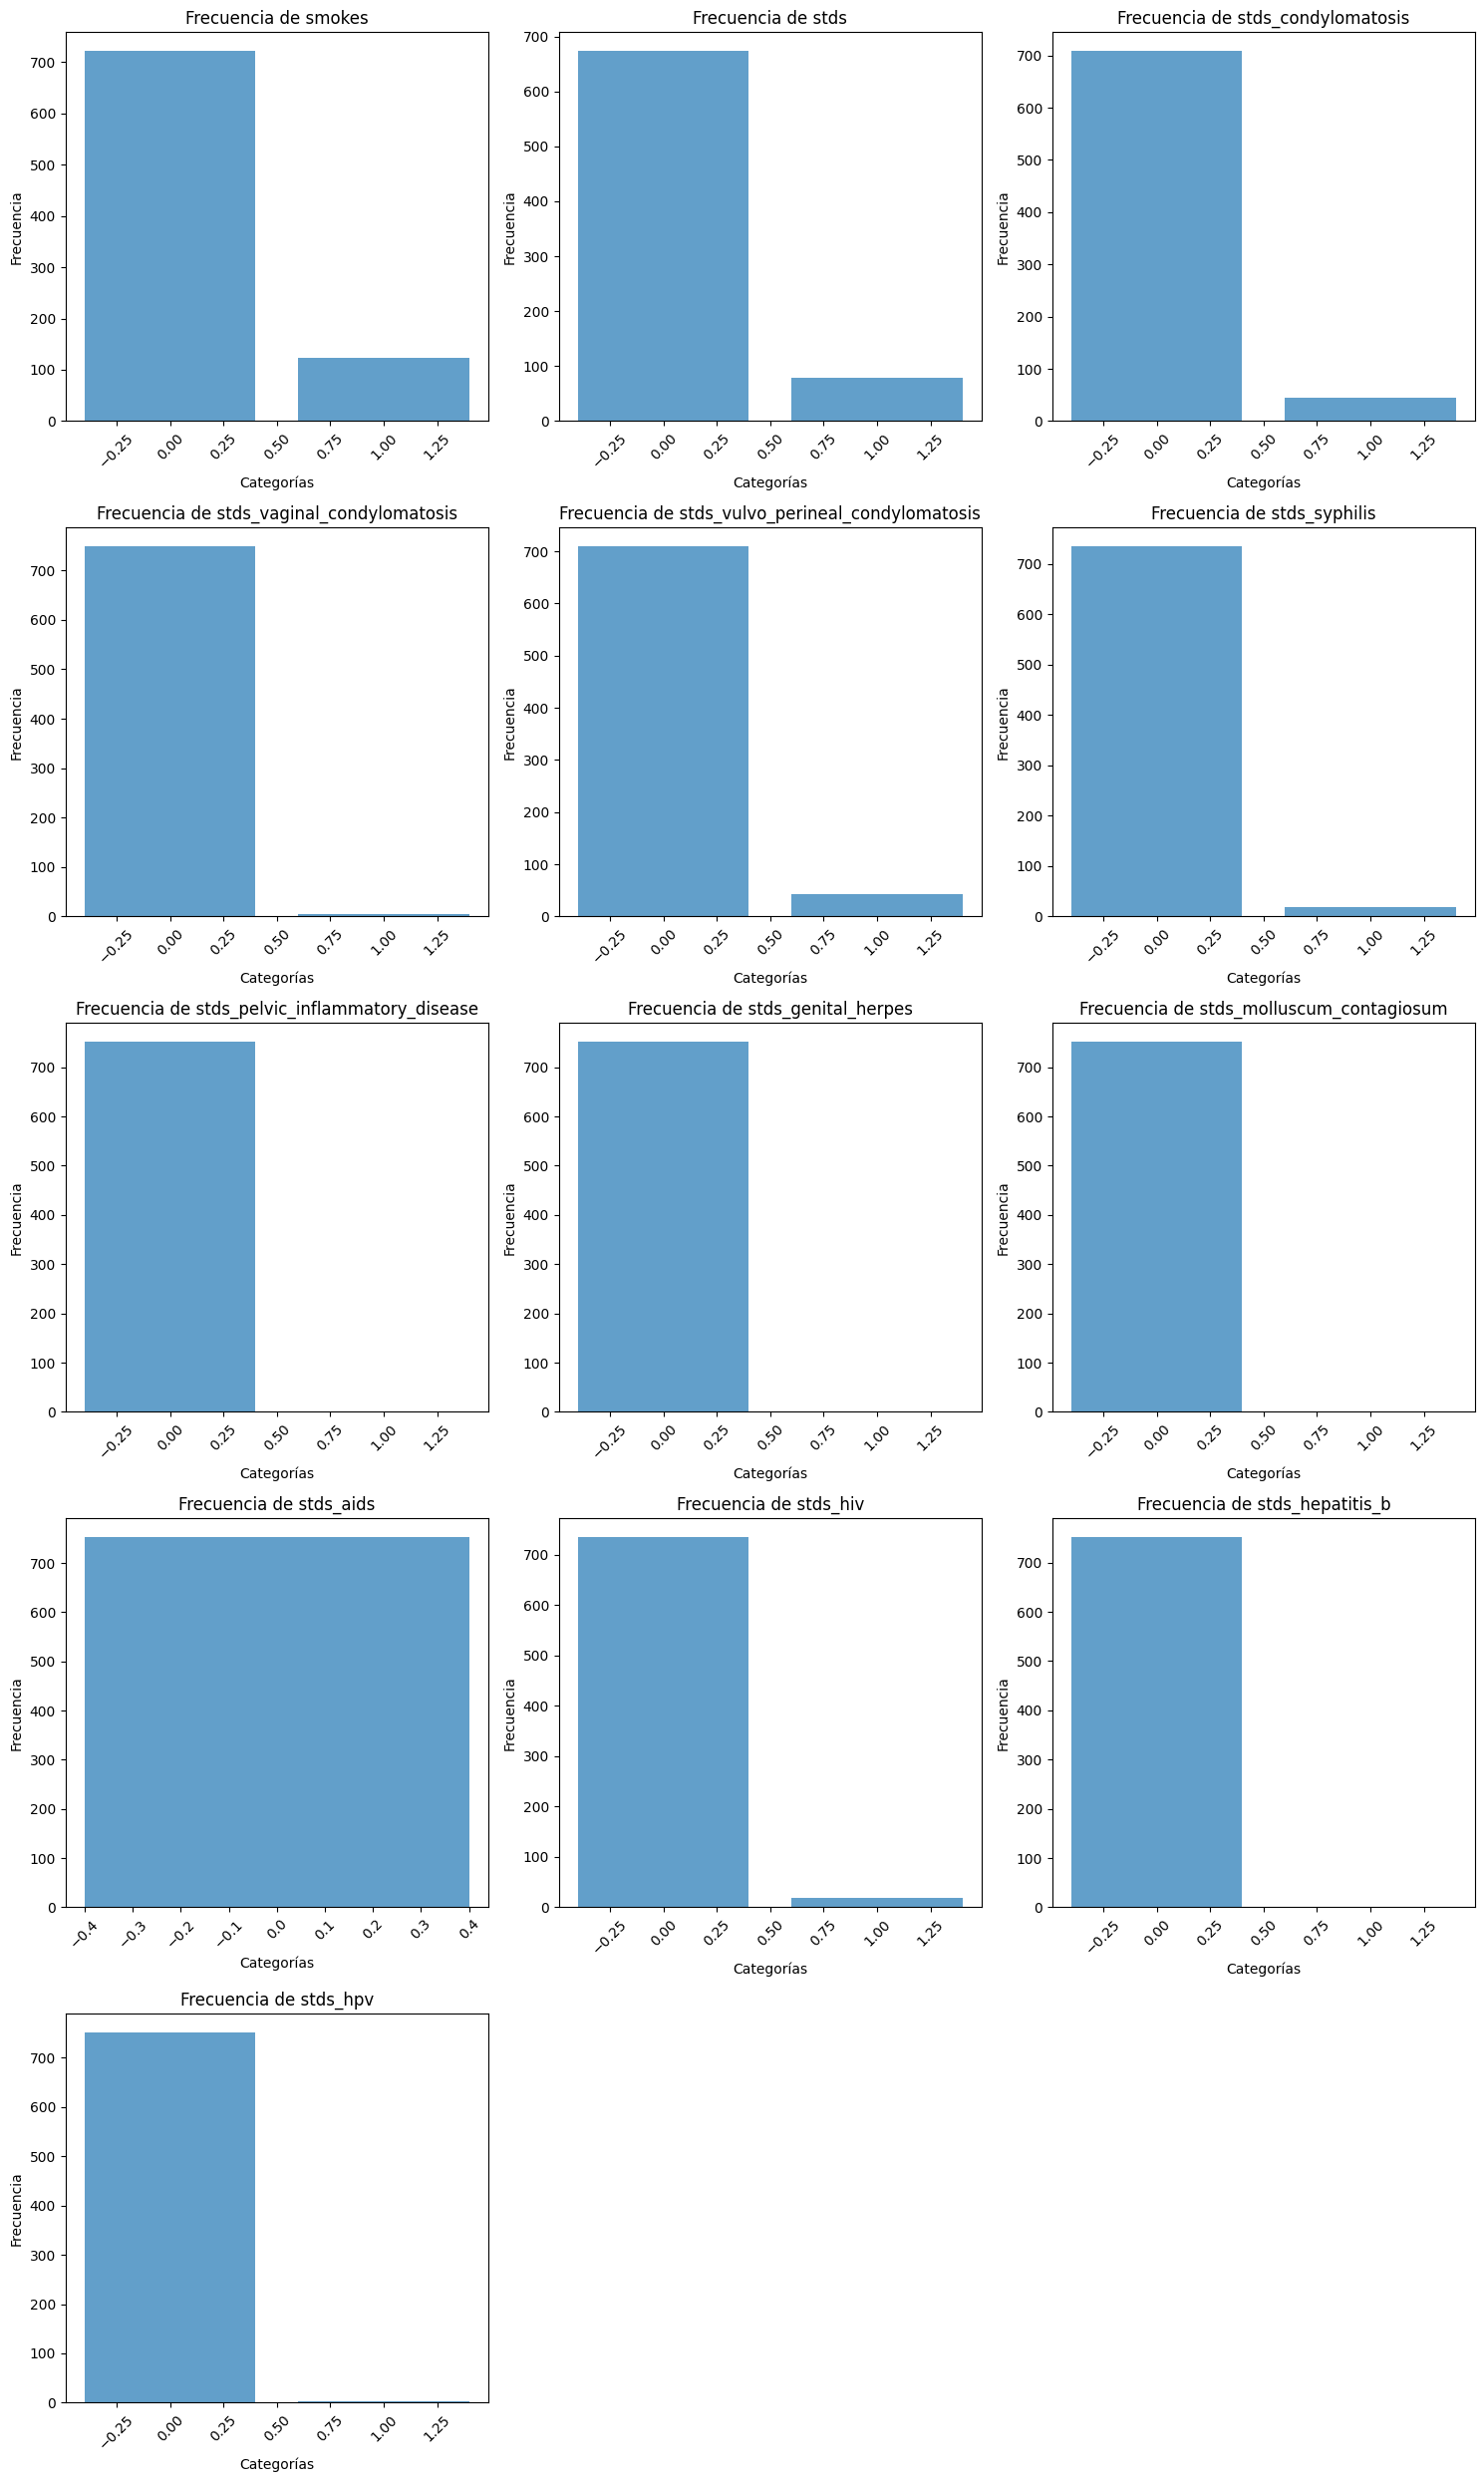

In [189]:
# Variables categoricas: dx_cancer, dx_cin, dx_hpv, dx, hinselmann, schiller, citology, biopsy, smokes, stds, stds_condylomatosis, stds_cervical_condylomatosis, stds_vaginal_condylomatosis, stds_vulvo_perineal_condylomatosis, stds_syphilis,stds_pelvic_inflammatory_disease, stds_genital_herpes, stds_molluscum_contagiosum, stds_aids, stds_hiv, stds_hepatitis_b, stds_hpv
frequency_data = {
	'smokes': data['smokes'].value_counts(),
	'stds': data['stds'].value_counts(),
	'stds_condylomatosis': data['stds_condylomatosis'].value_counts(),
	'stds_vaginal_condylomatosis': data['stds_vaginal_condylomatosis'].value_counts(),
	'stds_vulvo_perineal_condylomatosis': data['stds_vulvo_perineal_condylomatosis'].value_counts(),
	'stds_syphilis': data['stds_syphilis'].value_counts(),
	'stds_pelvic_inflammatory_disease': data['stds_pelvic_inflammatory_disease'].value_counts(),
	'stds_genital_herpes': data['stds_genital_herpes'].value_counts(),
	'stds_molluscum_contagiosum': data['stds_molluscum_contagiosum'].value_counts(),
	'stds_aids': data['stds_aids'].value_counts(),
	'stds_hiv': data['stds_hiv'].value_counts(),
	'stds_hepatitis_b': data['stds_hepatitis_b'].value_counts(),
	'stds_hpv': data['stds_hpv'].value_counts(),
}

frequency_rows = len(frequency_data.keys()) // 3 + 1
frequency_cols = 3

fig, axs = plt.subplots(frequency_rows, frequency_cols, figsize=(15, 5 * frequency_rows))
axs = axs.flatten()

# Plot each categorical variable on its corresponding subplot
for i, (variable, ax) in enumerate(zip(frequency_data.keys(), axs)):
    freq = frequency_data[variable]
    ax.bar(freq.index, freq.values, alpha=0.7)
    ax.set_title(f'Frecuencia de {variable}')
    ax.set_xlabel('Categorías')
    ax.set_ylabel('Frecuencia')
    ax.tick_params(axis='x', rotation=45)
# Eliminar subplots vacíos
for i in range(len(frequency_data.keys()), frequency_rows * frequency_cols):
    fig.delaxes(axs[i])
plt.tight_layout()
plt.show()






La variable categórica con más valores `1.0` es `smokes`, seguida por `stds`. Procedemos a realizar tablas de contingencia.



In [190]:
# Creando tablas de contingencia
contingency_tables = []
for variable in categorical_vars:
    contingency_table = pd.crosstab(data[variable], data['dx_cancer'])
    contingency_tables.append((variable, contingency_table))

contingency_tables = contingency_tables[1:]

for variable, table in contingency_tables:
    print(f"Contingency Table for '{variable}' vs. 'dx_cancer':")
    print(table)
    print('\n')

Contingency Table for 'dx_cin' vs. 'dx_cancer':
dx_cancer  0.0  1.0
dx_cin             
0.0        831   18
1.0          9    0


Contingency Table for 'dx_hpv' vs. 'dx_cancer':
dx_cancer  0.0  1.0
dx_hpv             
0.0        838    2
1.0          2   16


Contingency Table for 'dx' vs. 'dx_cancer':
dx_cancer  0.0  1.0
dx                 
0.0        830    4
1.0         10   14


Contingency Table for 'hinselmann' vs. 'dx_cancer':
dx_cancer   0.0  1.0
hinselmann          
0.0         809   14
1.0          31    4


Contingency Table for 'schiller' vs. 'dx_cancer':
dx_cancer  0.0  1.0
schiller           
0.0        773   11
1.0         67    7


Contingency Table for 'citology' vs. 'dx_cancer':
dx_cancer  0.0  1.0
citology           
0.0        800   14
1.0         40    4


Contingency Table for 'biopsy' vs. 'dx_cancer':
dx_cancer  0.0  1.0
biopsy             
0.0        791   12
1.0         49    6


Contingency Table for 'smokes' vs. 'dx_cancer':
dx_cancer  0.0  1.0
smokes        

# Análisis de Componentes Principales
Primero se procede a identificar si vale la pena realizar un PCA. Esto a través del test de `Bartlett` y el índice `KMO`.

### Test de Bartlett

In [191]:
data_copy = data.copy()
data_copy = data_copy.fillna(0)
chi_sq, p_value = calculate_bartlett_sphericity(data_copy.iloc[:,0:18])
chi_sq, p_value

(9850.356722627988, 0.0)

Obtenemos un `0.0`, se rechaza la hipótesis nula. Esto se puede observar en la matríz de correlación dado que no es una matríz de identidad.
### Índice KMO

In [192]:
kmo, model_kmo = calculate_kmo(data_copy.iloc[:,0:18])
model_kmo

/Users/saramariapaguagagonzales/.pyenv/versions/3.11.3/lib/python3.11/site-packages/factor_analyzer/utils.py:244: UserWarning:

The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.



0.6319802922730177

Este valor es mayor a 0.5. Esto indica una correlación moderada entre las variables. Por lo tanto, si se puede proceder con un PCA. Sin embargo se debe de tener cuidado porque algunas variables pueden estar debilmente correlacionadas.

### PCA

In [193]:
pca_pipe = make_pipeline(StandardScaler(),PCA()) #Se escalan los datos y luego se le aplica PCA
pca_pipe.fit(data_copy)
#Se extrae el modelo del pipeline
modelo_pca = pca_pipe.named_steps['pca']

#Se convierte el arreglo en data frame
pd.DataFrame(
    data = modelo_pca.components_,
    columns = data_copy.columns,
)


age  num_sexual_partners  first_sexual_intercourse   
0   2.778333e-02         3.822278e-02              1.038287e-02  \
1   1.738170e-01         5.483536e-02              4.521384e-02   
2   1.901302e-01         2.056751e-01             -6.773199e-02   
3   5.335290e-02         3.829297e-02              3.800452e-02   
4  -4.396983e-01         3.930262e-02             -2.387526e-01   
5   2.765344e-02        -2.488009e-02             -6.478537e-02   
6  -1.862326e-01        -8.511121e-02             -6.154748e-02   
7   1.840056e-01        -3.209339e-01              5.639674e-01   
8   3.176446e-01        -1.088853e-01              2.044565e-01   
9  -7.769626e-02        -2.676603e-01              9.240458e-02   
10  1.134062e-01         2.436687e-01              1.500569e-01   
11 -4.705341e-02         1.677419e-01             -2.914047e-02   
12 -1.573930e-01        -4.972429e-01             -8.443798e-02   
13  5.220310e-02         3.901187e-02              3.153735e-01   
14 -7.186886e-02        -9.080685e-02              3.047797e-01   
15  5.634976e-02         1.477526e-01             -2.783537e-01   
16 -5.936385e-02         5.439360e-01              3.216232e-01   
17  7.917220e-02        -2.753742e-01             -1.277442e-01   
18  1.353013e-01        -1.398556e-02             -4.855195e-02   
19  1.762678e-01         8.951937e-03             -1.386163e-01   
20  9.258364e-02         9.345510e-02             -8.941816e-02   
21 -1.608689e-02         4.136324e-02              3.872821e-02   
22  6.376214e-01        -5.471632e-02             -3.231390e-01   
23 -1.445676e-01         2.394725e-02              4.400457e-02   
24 -1.160812e-01         5.665068e-02              1.928766e-02   
25  1.437029e-02        -1.485956e-02             -2.103777e-02   
26  1.940526e-02        -5.612087e-03              2.268944e-03   
27  1.833957e-03        -5.610853e-03             -6.393790e-03   
28 -2.466206e-05         3.553671e-03              1.613715e-03   
29  1.962331e-03         2.130116e-03              1.194942e-03   
30 -2.497464e-03        -1.739261e-03              7.239531e-03   
31  4.409597e-17        -9.268852e-17             -2.888848e-16   
32 -0.000000e+00        -3.077385e-17              4.331040e-17   

    num_pregnancies        smokes  smokes_years  smokes_packs_year   
0      2.977644e-02  7.258774e-02  7.431858e-02       4.312853e-02  \
1      1.086639e-01  8.444195e-02  1.431027e-01       1.342680e-01   
2      2.041672e-01  4.731328e-01  5.274362e-01       4.674597e-01   
3      1.162622e-03 -3.504379e-02 -3.205698e-02       7.912958e-03   
4     -4.010927e-01  2.023901e-01  1.626459e-01       1.784185e-01   
5      6.723943e-02 -7.971520e-02 -8.640490e-02      -8.725128e-02   
6     -1.452118e-02 -2.061628e-02 -5.794866e-02      -4.010157e-02   
7     -1.403204e-01 -5.110389e-02  8.635090e-02       7.661434e-02   
8      3.764223e-01 -7.095932e-02  1.134536e-02      -4.754378e-02   
9     -9.678126e-02  6.318764e-02  7.641542e-02       6.706864e-02   
10    -8.881889e-02 -3.207093e-03  7.071581e-03       9.359885e-03   
11    -4.190257e-03 -3.868361e-02 -3.534946e-02       9.316157e-03   
12    -8.781209e-02  5.310167e-02  8.589196e-02       4.226839e-02   
13    -2.602310e-01  1.333864e-01  6.189401e-02      -3.794337e-02   
14    -2.413766e-01  9.605734e-02  3.653144e-02       6.478172e-02   
15     1.826808e-01  4.740679e-03 -2.837867e-02      -2.195826e-01   
16    -1.951667e-01  3.420688e-02 -1.134575e-01      -1.248672e-01   
17     1.055632e-01  4.125665e-02  3.549180e-02       6.568820e-03   
18     3.640050e-02  4.465010e-02 -1.451452e-02      -8.112447e-02   
19    -3.781755e-01  5.367716e-03 -3.429316e-02      -2.939892e-02   
20    -1.095305e-01 -6.857571e-01 -2.539306e-02       6.488263e-01   
21     1.520157e-02  7.804583e-03  1.120311e-03      -6.007167e-03   
22    -4.758054e-01  2.686400e-02  6.430622e-02      -1.697138e-01   
23     3.818280e-02 -9.731738e-02  9.536446e-02       

### Representación de las variables en cada una de las componentes

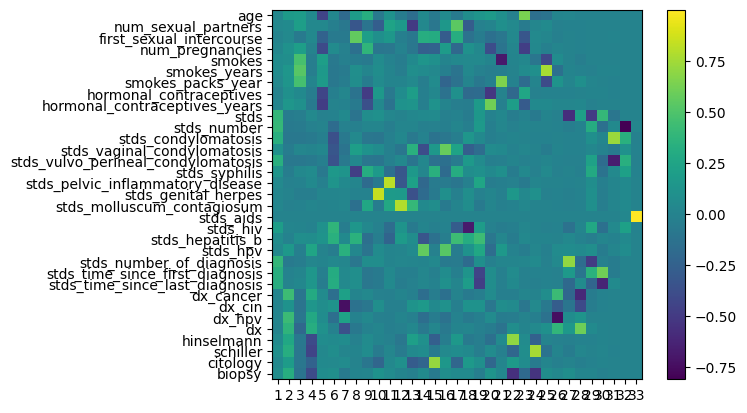

In [194]:
fig, ax = plt.subplots(nrows=1, ncols=1)
components = modelo_pca.components_
plt.imshow(components.T)
plt.yticks(range(len(data_copy.columns)), data_copy.columns)
plt.xticks(range(len(data_copy.columns)), np.arange(modelo_pca.n_components_)+1)
plt.grid(False)
plt.colorbar();

### Scree Plot

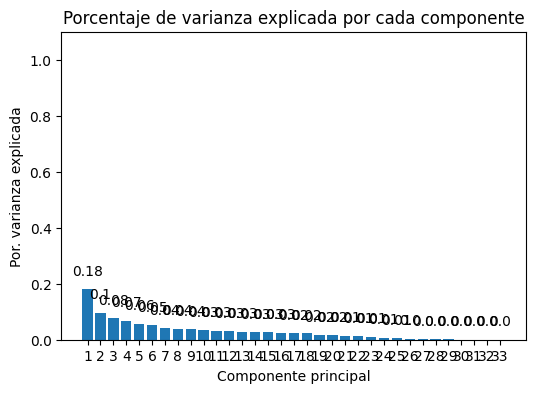

In [195]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.bar(
    x      = np.arange(modelo_pca.n_components_) + 1,
    height = modelo_pca.explained_variance_ratio_
)

for x, y in zip(np.arange(len(data_copy.columns)) + 1, modelo_pca.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)
ax.set_ylim(0, 1.1)
ax.set_title('Porcentaje de varianza explicada por cada componente')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza explicada');

La componente tiene un mayor porcentaje en la explicación de la varianza. Finalizamos un análisis visualizando el porcentaje de la varianza acumulada.

In [196]:
acc_varian = modelo_pca.explained_variance_ratio_.cumsum()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.plot(
    np.arange(len(data_copy.columns)) + 1,
    acc_varian,
    marker = 'o'
)

for x, y in zip(np.arange(len(data_copy.columns)) + 1, acc_varian):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )
    
ax.set_ylim(0, 1.1)
ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)
ax.set_title('Porcentaje de varianza explicada acumulada')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza acumulada');

### Reglas de asociación

In [197]:
cats_vars = ['dx_cancer', 'dx_cin', 'dx_hpv', 'dx', 'hinselmann', 'stds', 'schiller', 'citology', 'biopsy', 'smokes', 'stds_condylomatosis', 'stds_vaginal_condylomatosis', 'stds_vulvo_perineal_condylomatosis', 'stds_syphilis','stds_pelvic_inflammatory_disease', 'stds_genital_herpes', 'stds_molluscum_contagiosum', 'stds_aids', 'stds_hiv', 'stds_hepatitis_b', 'stds_hpv']

In [198]:

categoricas = data_copy[cats_vars]
categoricas = categoricas.astype(object)
categoricas['dx_cancer'].replace({0:'no_cancer', 1:'has_cancer'}, inplace=True)
categoricas['dx_cin'].replace({0:'no_cin', 1:'has_cin'}, inplace=True)
categoricas['dx_hpv'].replace({0:'no_hpv', 1:'has_hpv'}, inplace=True)
categoricas['dx'].replace({0:'no_diagosis', 1:'has_diagnosis'}, inplace=True)
categoricas['hinselmann'].replace({0:'no_hinselmann', 1:'done_hinselmann'}, inplace=True)
categoricas['schiller'].replace({0:'no_schiller', 1:'done_schiller'}, inplace=True)
categoricas['citology'].replace({0:'no_citology', 1:'done_citology'}, inplace=True)
categoricas['biopsy'].replace({0:'no_biopsy', 1:'done_biopsy'}, inplace=True)
categoricas['smokes'].replace({0:'doesnt_smoke', 1:'smokes'}, inplace=True)
categoricas['stds_condylomatosis'].replace({0:'no_condylomatosis', 1:'has_condylomatosis'}, inplace=True)
categoricas['stds_vaginal_condylomatosis'].replace({0:'no_vaginal_condylomatosis', 1:'has_vaginal_condylomatosis'}, inplace=True)
categoricas['stds_vulvo_perineal_condylomatosis'].replace({0:'no_vulvo_perineal_condylomatosis', 1:'has_vulvo_perineal_condylomatosis'}, inplace=True)
categoricas['stds_syphilis'].replace({0:'no_syphilis', 1:'has_syphilis'}, inplace=True)
categoricas['stds_pelvic_inflammatory_disease'].replace({0:'no_pelvic_inflammatory_disease', 1:'has_pelvic_inflammatory_disease'}, inplace=True)
categoricas['stds_genital_herpes'].replace({0:'no_genital_herpes', 1:'has_genital_herpes'}, inplace=True)
categoricas['stds_molluscum_contagiosum'].replace({0:'no_molluscum_contagiosum', 1:'has_molluscum_contagiosum'}, inplace=True)
categoricas['stds_aids'].replace({0:'no_aids', 1:'has_aids'}, inplace=True)
categoricas['stds_hiv'].replace({0:'no_hiv', 1:'has_hiv'}, inplace=True)
categoricas['stds_hepatitis_b'].replace({0:'no_hepatitis_b', 1:'has_hepatitis_b'}, inplace=True)
categoricas['stds_hpv'].replace({0:'no_hpv', 1:'has_hpv'}, inplace=True)

# Discretizando variables cuantitativas
data_copy['num_sexual_partners'] = pd.cut(data_copy['num_sexual_partners'], labels=['none', 'few', 'moderate', 'much', 'many'], bins=[0, 1, 2, 5, 10, 30])
data_copy['first_sexual_intercourse'] = pd.cut(data_copy['first_sexual_intercourse'], bins=[0, 12, 18, 25, 100], labels=['child', 'teenager', 'young_adult', 'adult'])
data_copy['num_pregnancies'] = pd.cut(data_copy['num_pregnancies'], bins=[0, 1, 3, 5, 10, 15], labels=['none', 'low', 'medium', 'much', 'very_much'])
data_copy['smokes_years'] = pd.cut(data_copy['smokes_years'], bins=[0, 5, 10, 20, 30, 45], labels=['very_short_term', 'short_term', 'medium_term', 'long_term', 'very_long_term'])
data_copy['smokes_packs_year'] = pd.cut(data_copy['smokes_packs_year'], bins=[0, 1, 5, 10, 20, 50], labels=['none', 'few', 'moderate', 'many', 'excessive'])
data_copy['hormonal_contraceptives_years'] = pd.cut(data_copy['hormonal_contraceptives_years'], bins=[0, 5, 10, 20, 30, 45], labels=['very_short_term', 'short_term', 'medium_term', 'long_term', 'very_long_term'])
data_copy['stds_time_since_first_diagnosis'] = pd.cut(data_copy['stds_time_since_first_diagnosis'], bins=[0, 5, 10, 20, 30], labels=['very_recent', 'recent', 'past', 'long_ago'])
data_copy['stds_time_since_last_diagnosis'] = pd.cut(data_copy['stds_time_since_last_diagnosis'], bins=[0, 5, 10, 20, 30], labels=['very_recent', 'recent', 'past', 'long_ago'])



In [199]:
print(categoricas.shape)
data_all = pd.concat([categoricas, data_copy[['age', 'num_sexual_partners', 'first_sexual_intercourse', 'num_pregnancies', 'smokes_years', 'smokes_packs_year', 'hormonal_contraceptives_years', 'stds_time_since_first_diagnosis', 'stds_time_since_last_diagnosis']]], axis=1)
data_all = data_all.astype(str)
records = [[str(data_all.values[i, j]) for j in range(data_all.shape[1])] for i in range(data_all.shape[0])]


(858, 21)


In [204]:
reglas_asociacion = apriori(records,min_support=0.2, min_confidence = 0.8, max_length = 3)
reglas = list(reglas_asociacion)

In [205]:
reglas_asociacion2 = apriori(records,min_support=0.4, min_confidence = 0.6, max_length = 3)
reglas2 = list(reglas_asociacion2)

In [217]:
output = list(reglas)
def inspect(output):
    lhs = [tuple(result[2][0][0])[0] for result in output if len(result[2][0][0]) > 0]
    rhs = [tuple(result[2][0][1])[0] for result in output if len(result[2][0][1]) > 0]
    support    = [result[1] for result in output]
    confidence = [result[2][0][2] for result in output]
    lift       = [result[2][0][3] for result in output]
    return list(zip(lhs, rhs, support, confidence, lift))
output_DataFrame = pd.DataFrame(inspect(output), columns = ['Left_Hand_Side', 'Right_Hand_Side', 'Support', 'Confidence', 'Lift'])
output_DataFrame

Left_Hand_Side Right_Hand_Side   Support  Confidence      Lift
0                 0.0             0.0  0.907925    0.907925  1.000000
1                 few    doesnt_smoke  0.856643    0.856643  1.000000
2                 low             nan  0.990676    0.990676  1.000000
3            moderate         no_aids  1.000000    1.000000  1.000000
4                none       no_biopsy  0.935897    0.935897  1.000000
...               ...             ...       ...         ...       ...
1584  very_short_term       no_biopsy  0.890443    0.890443  1.000000
1585  very_short_term       no_biopsy  0.470862    0.950588  1.024629
1586         teenager       no_biopsy  0.730769    0.927515  0.999758
1587  very_short_term       no_biopsy  0.435897    0.928040  1.000324
1588  very_short_term       no_cancer  0.959207    0.959207  1.000000

[1589 rows x 5 columns]

In [209]:
output2 = list(reglas2)
output_DataFrame2 = pd.DataFrame(inspect(output2), columns = ['Left_Hand_Side', 'Right_Hand_Side', 'Support', 'Confidence', 'Lift'])
output_DataFrame2

Left_Hand_Side Right_Hand_Side   Support  Confidence  Lift
0               none             0.0  0.907925    0.907925   1.0
1    very_short_term    doesnt_smoke  0.856643    0.856643   1.0
2               none             nan  0.990676    0.990676   1.0
3                low         no_aids  1.000000    1.000000   1.0
4                low       no_biopsy  0.935897    0.935897   1.0
..               ...             ...       ...         ...   ...
606  very_short_term       no_biopsy  0.794872    0.794872   1.0
607             none       no_biopsy  0.792541    0.792541   1.0
608  very_short_term       no_biopsy  0.803030    0.803030   1.0
609             none       no_biopsy  0.803030    0.803030   1.0
610  very_short_term       no_biopsy  0.803030    0.803030   1.0

[611 rows x 5 columns]

In [213]:
reglas_asociacion3 = apriori(records,min_support=0.02, min_confidence = 0.3, max_length = 3)
reglas3 = list(reglas_asociacion3)

In [225]:
output3 = list(reglas3)
output_DataFrame3 = pd.DataFrame(inspect(output3), columns = ['Left_Hand_Side', 'Right_Hand_Side', 'Support', 'Confidence', 'Lift'])
output_DataFrame3


Left_Hand_Side                    Right_Hand_Side   
0                                   15.0                                0.0  \
1                                   16.0                       doesnt_smoke   
2                                   17.0                                few   
3                                   18.0                                low   
4                                   19.0                           moderate   
5                                   20.0                                nan   
6                                   21.0                            no_aids   
7                                   22.0                          no_biopsy   
8                                   23.0                          no_cancer   
9                                   24.0                             no_cin   
10                                  25.0                        no_citology   
11                                  26.0                  no_condylomatosis   
12                                  27.0                        no_diagosis   
13                                  28.0                  no_genital_herpes   
14                                  29.0                     no_hepatitis_b   
15                                  30.0                      no_hinselmann   
16                                  31.0                             no_hiv   
17                                  33.0                             no_hpv   
18                                  34.0           no_molluscum_contagiosum   
19                                  35.0     no_pelvic_inflammatory_disease   
20                                  36.0                        no_schiller   
21                                 adult                        no_syphilis   
22                           done_biopsy          no_vaginal_condylomatosis   
23                         done_citology   no_vulvo_perineal_condylomatosis   
24                       done_hinselmann                               none   
25                         done_schiller                           teenager   
26                         has_diagnosis                    very_short_term   
27                                medium                                0.0   
28                           medium_term                                0.0   
29                                  much                                0.0   
30                            short_term                                0.0   
31                                smokes                                0.0   
32                           young_adult                                0.0   
33                                   1.0                                0.0   
34                                   1.0                                0.0   
35                                   1.0                                0.0   
36                               has_hiv                                0.0   
37                          has_syphilis                                0.0   
38                                   1.0                                0.0   
39                                   1.0                                0.0   
40                                   1.0                                0.0   
41                                   1.0                                0.0   
42                                   1.0                                0.0   
43                                   1.0                                0.0   
44                                   1.0                                0.0   
45                                   1.0                                0.0   
46                                   1.0                                0.0   
47                                   1.0                                0.0   
48                                   1.0                                0.0   
49                                   1.0                                0.0 

Conforme se varia el soporte y la confianza, se obtienen diferentes cantidades y tipos de reglas de asociación. En este caso, se obtuvieron 3 conjuntos de reglas de asociación. A pesar de que los parametros variaron el valor de lift se mantuvo cercano a 1 lo que indica que ocurren juntos menos seguido de los esperado. Algunas reglas interesantes que se pueden mencionar son: si se ha hecho el examen de schiller entonces es una paciente adolescente 

# Análisis de resultados
### Respuestas a las preguntas
- Fumar no demostró ser un factor significativo para un diagnóstico positivo de cáncer. Luego de el análisis de componetes principales se puede observar que la edad es una variable con más peso en el resultado.
- El número de parejas sexuales es un factor importante en el diagnóstico. El gráfico de porcentaje de varianza explicada por cada componente demuestra que es el segundo componente con más peso.
